# Applied Capstone Project Week 5. Demand Profile Analytics For VPP

## Table of Contents

1. [Introduction](#intro)
1. [Business Understanding](#business_understanding)
1. [Data Understanding and Preparation](#data)
1. [Methodology](#method)
    1. [KMeans](#kmeans)
    1. [Affinity Propagation](#affinity)
    1. [DBSCAN](#dbscan)
1. [Results](#results)
1. [Discussion](#discussion)
1. [Conclusion](#conclusion)

## 1. Introduction

<a id="intro"></a>

The electricity sector is changing rapidly and previously one-way market relationships between energy producers and consumers are no longer a single option. The course for decarbonisation, digitalisation and decentralisation has become a new strategic plan for the industry development. More often small and medium consumers of energy seek for greener and more profitable solutions, like solar panels, storage systems. These new market agents are called prosumers — consumers that produce energy.

Electricity is a unique product due to its physical characteristics and is traded on the so-called Day Ahead Markets - for each hour of the next day. Thus, prosumers should keep their eye on volumes they consume and produce, as renewable energy generation is intermittent and from time to time prosumers still need to buy energy from the grid. And what to do during periods where they produce more energy than you can consume or store? 

One of the possible local solutions is a creation of Virtual Power Plant (VPP) - an aggregator of prosumers that regulates their relationships with each other and the energy system. 

This project is inspired by the 2017 course “Qualitative Methods In Energy Economics” by Sergey Syntulsky. 


## 2. Business Understanding

<a id="business_understanding"></a>

Technically, VPP is an entity that optimises energy flows within group and the market given existing distribution system constraints. Energy consumption is uneven with picks during the working hours and bottoms at night. The distribution depends on the production processes of each prosumer type. For example, fridges in warehouses usually work uniformly throughout the day, on the opposite, office buildings need more energy from 9:00 am till 18:00 and private houses — before 9:00 and after 18:00. At the same time, power generation of solar PV systems directly connected to the level of solar radiation during the day. 

Thus, the demand profile of a set of prosumers varies through a day, week and season. For VPP it is important to know typical behaviour of demand curve - demand profile. This is the first question VPP developers should define for themselves after the set of prosumers is defined. However, what is the best algorithm for clustering hourly consumption data to find the most accurate estimate of daily demand profile?

In this project we would compare three clustering methods in order to find the answer:
- K-means;
- Affinity propagation;
- DBSCAN 

## 3. Data Understanding and Preparation

<a id="data"></a>

For this project the [open source data](https://data.lab.fiware.org//dataset/874ac2ac-1920-4639-a661-fab4864b7647/resource/06a22cae-694c-40a7-aabf-a0ddfe0611e8/download/ternipowerdemandalldata.csv) from Trial Site Terni, Italy. The trial took place at a small network segment that connected prosumers with solar power plants and a hydroelectric power station. The data set provides power demand/supply profiles in kW of customers in different energy sectors from 02/04/2014 to 27/07/2015.

In [1]:
#Set the environment

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
from datetime import datetime

In [2]:
#Read the data into pandas dataframe

url = 'https://data.lab.fiware.org//dataset/' + \
            "874ac2ac-1920-4639-a661-fab4864b7647/resource/" + \
            "06a22cae-694c-40a7-aabf-a0ddfe0611e8/download/" + \
            "ternipowerdemandalldata.csv"

dFrame = pd.read_csv(url, sep = ';') #create a dataframe
dFrame.columns = ['datetime', 'value', 'customer'] #rename columns for convenience

dFrame.head()

,datetime,value,customer
0,2014-04-02T00:16:04+02:00,12.0,SecondarySubstation
1,2014-04-02T00:16:04+02:00,187.0,CustomerLighting
2,2014-04-02T00:16:10+02:00,10.0,CustomerCommercial_2
3,2014-04-02T00:16:12+02:00,22.0,CustomerOffice_1
4,2014-04-02T00:16:14+02:00,65.0,CustomerOffice_2


In [3]:
#Datetime column contains extra information (timezone) and it is better to drop it for further convenience

dFrame[['datetime','timeshift']] = dFrame.datetime.str.split("+",expand=True) #split datetime column into 'datetime' and 'timeshift'

dFrame.datetime = pd.to_datetime(dFrame['datetime'], format="%Y-%m-%dT%H:%M:%S") #convert into datetime format

dFrame['date'] = dFrame.datetime.dt.date #create new column with dates
dFrame['hour'] = dFrame.datetime.dt.hour #create new columns with hours

dFrame.tail()

,datetime,value,customer,timeshift,date,hour
1040409,2015-07-27 09:49:43,16.0,SecondarySubstation,02:00,2015-07-27,9
1040410,2015-07-27 09:54:43,51.0,CustomerOffice_1,02:00,2015-07-27,9
1040411,2015-07-27 09:54:43,21.0,SecondarySubstation,02:00,2015-07-27,9
1040412,2015-07-27 09:54:44,72.0,CustomerIndustrial_1,02:00,2015-07-27,9
1040413,2015-07-27 09:59:46,10.0,SecondarySubstation,02:00,2015-07-27,9


In [4]:
#Create a new dataFrame with values grouped by date and hour

demand = dFrame.groupby(['date', 'hour']).sum().reset_index()


demand.head()

,date,hour,value
0,2014-04-02,0,2642.0
1,2014-04-02,1,3270.0
2,2014-04-02,2,3382.0
3,2014-04-02,3,3170.0
4,2014-04-02,4,3495.0


In [5]:
#Create a new column with the day number

demand['day'] = demand.groupby('hour').cumcount()

demand.tail()

,date,hour,value,day
7360,2015-07-27,5,2665.0,294
7361,2015-07-27,6,1123.0,295
7362,2015-07-27,7,3014.0,294
7363,2015-07-27,8,3873.0,294
7364,2015-07-27,9,3938.0,298


In [6]:
# Here is descriptive statistics of our data

demand['value'].describe()

count      7365.000000
mean       7025.933605
std       14484.247148
min           0.000000
25%        2124.000000
50%        3847.000000
75%        6243.000000
max      704515.000000
Name: value, dtype: float64

Average consumption within of the VPP is 7025 kW per hour with standard deviation - 14484 kW per hour.

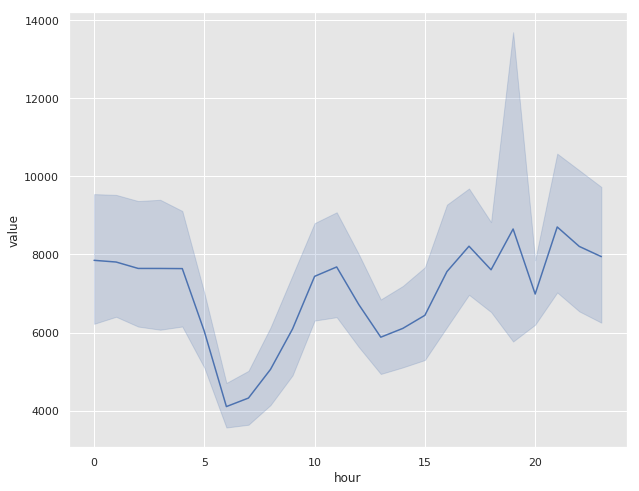

In [48]:
# Let`s look at the avarage daily demand profile of our VPP

import seaborn as sns #import seaborn

sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.lineplot(x = demand.hour, y = demand.value, sort = False) #create plot

On average, there is a deep dive in energy demand between 4 and 6 am and another, but smaller during the lunch time. The load has two picks at 19:00 and 21:00 with possible outliers to almost 14 MW.

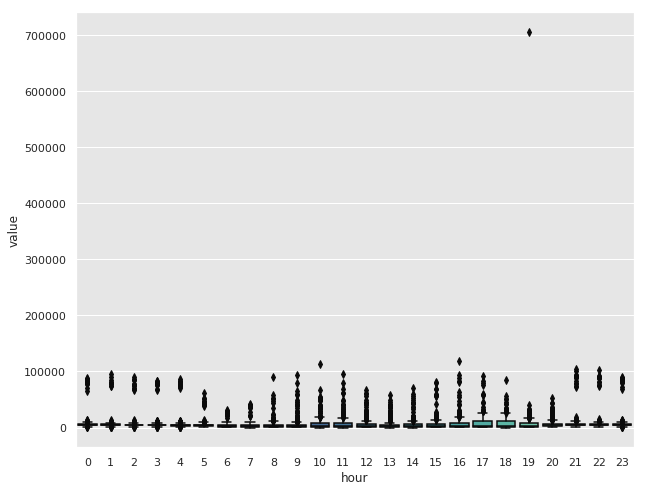

In [49]:
#Let`s look at the box plot of the VPP demand per each hour

sns.boxplot(x = 'hour', y = 'value', data = demand, palette = 'mako')

As it is clear from the box plot, there are outliers that can bias our demand profile

In [9]:
#Let`s detect outliers that appear on the boxplot above

Q1 = np.percentile(demand.value, 25)
Q3 = np.percentile(demand.value, 75)
    
IQR = Q3 - Q1

demand['outlier'] = np.where((demand.value < Q1 - 1.5 * IQR) | (demand.value > Q3 + 1.5 * IQR), 1, 0)
demand.head()

,date,hour,value,day,outlier
0,2014-04-02,0,2642.0,0,0
1,2014-04-02,1,3270.0,0,0
2,2014-04-02,2,3382.0,0,0
3,2014-04-02,3,3170.0,0,0
4,2014-04-02,4,3495.0,0,0


In [10]:
#Let`s copy demand with removed outliers to a new dataframe

demand_x = demand[demand.outlier == 0]

demand_x.dropna(inplace = True)

demand_x.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,hour,value,day,outlier
0,2014-04-02,0,2642.0,0,0
1,2014-04-02,1,3270.0,0,0
2,2014-04-02,2,3382.0,0,0
3,2014-04-02,3,3170.0,0,0
4,2014-04-02,4,3495.0,0,0


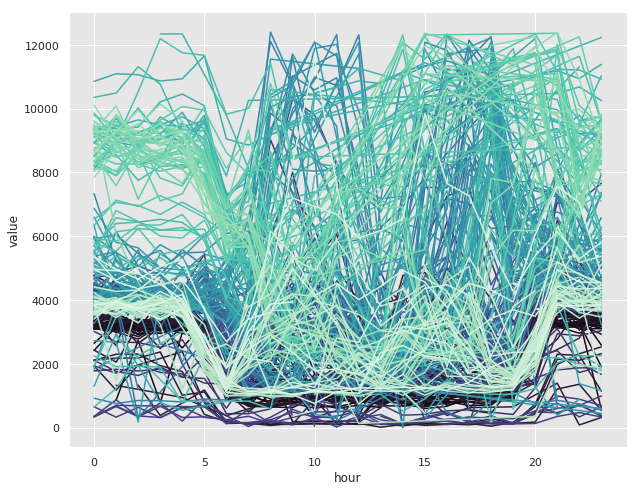

In [50]:
#Let`s plot a line plot showing the demand for each day and hour

sns.lineplot(data = demand_x, x = 'hour', y = 'value', hue = 'date', legend = False, palette = 'mako')

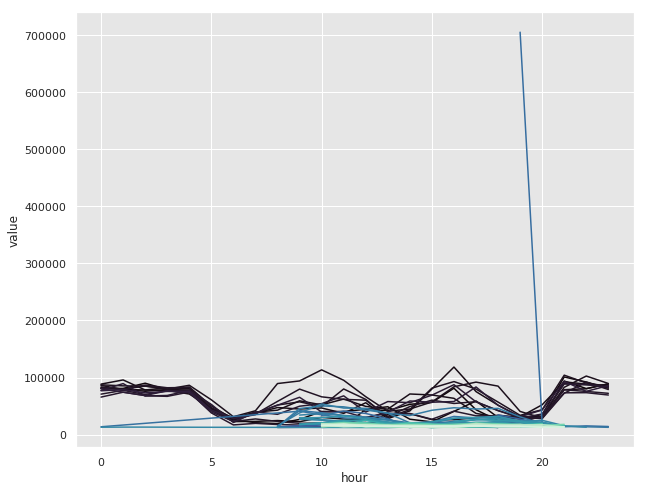

In [51]:
#Let`s look at the outliers

demand_y = demand[demand.outlier == 1]

sns.lineplot(data = demand_y, x = 'hour', y = 'value', hue = 'date', legend = False, palette = 'mako')

In [13]:
#Pivot table for hours being seperate columns

df = demand_x.pivot(index = 'day', columns = 'hour', values = 'value')

df.head()

hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,,,,
0,2642.0,3270.0,3382.0,3170.0,3495.0,3154.0,2663.0,1030.0,1778.0,1775.0,2481.0,1840.0,759.0,1139.0,1517.0,1822.0,848.0,1176.0,886.0,1437.0,3093.0,3725.0,3459.0,3304.0
1,3373.0,3171.0,3199.0,3095.0,3105.0,3315.0,2647.0,703.0,1673.0,2369.0,850.0,1276.0,1052.0,1557.0,1457.0,1998.0,1525.0,1411.0,1352.0,1787.0,3361.0,3430.0,4141.0,3347.0
2,3333.0,3157.0,3325.0,3269.0,3177.0,3338.0,2929.0,1024.0,1590.0,3689.0,1673.0,1651.0,1797.0,1007.0,1159.0,1609.0,1514.0,2592.0,1895.0,1654.0,3437.0,3563.0,3563.0,2586.0
3,3132.0,3419.0,3344.0,3235.0,2496.0,3285.0,2845.0,869.0,1130.0,946.0,2040.0,943.0,923.0,847.0,997.0,650.0,819.0,693.0,705.0,1204.0,3097.0,3244.0,3314.0,3098.0
4,3422.0,3450.0,3226.0,3131.0,3226.0,3242.0,2335.0,1032.0,762.0,919.0,795.0,1610.0,658.0,670.0,984.0,736.0,826.0,802.0,707.0,1249.0,3491.0,3248.0,3200.0,3330.0


## 4. Methodology

<a id="method"></a>

For this project accuracy of three clustering methods would be tested. These methods are frequently used in the VPP research papers:
1. KMeans
1. Affinity Propagation;
1. DBSCAN

Let`s start

In [14]:
#Though values are of the same unit, let`s normalize it anyway

from sklearn.preprocessing import StandardScaler

X = df.values #features
X = np.nan_to_num(X)

cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-0.73226713, -0.48508265, -0.38674542, ..., -0.41455231,
        -0.51854343, -0.52992818],
       [-0.43330212, -0.5260219 , -0.46106677, ..., -0.52470894,
        -0.23795716, -0.51267316],
       [-0.44966135, -0.53181129, -0.40989469, ..., -0.4750451 ,
        -0.47575608, -0.81804686],
       ...,
       [-1.81279457, -1.83731846, -1.76026896, ..., -1.80551321,
        -1.9416342 , -1.85575567],
       [-1.81279457, -1.83731846, -1.76026896, ..., -1.80551321,
        -1.9416342 , -1.85575567],
       [-1.81279457, -1.83731846, -1.76026896, ..., -1.80551321,
        -1.9416342 , -1.85575567]])

### 4.1 KMeans

<a id="kmeans"></a>

KMeans is the simplest and most used algorithm that clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as **the inertia** or within-cluster sum-of-squares. **This algorithm requires the number of clusters to be specified.** It scales well to large number of samples and has been used across a large range of application areas in many different fields. 

[Text(0, 0.5, 'Inertia'), Text(0.5, 0, 'Number of clusters')]

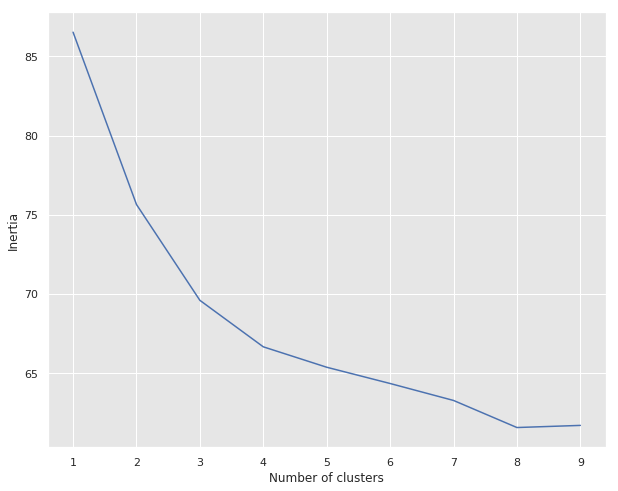

In [54]:
#Import KMeans library from sklearn, then define the optimal number of clusters and fit the model

from sklearn.cluster import KMeans 

inertia = []
for k in range(1, 10):
    km = KMeans(init = "k-means++", n_clusters = k, random_state=1).fit(cluster_dataset)
    inertia.append(np.sqrt(km.inertia_))

# Plot the inertia against 
ax = sns.lineplot(x = range(1, 10), y = inertia, dashes = False, sort=False) #create plot
ax.set(xlabel = 'Number of clusters', ylabel = 'Inertia') #set axis labels

We see that the inertia decreases significantly until the number of clusters is 4 and then does not change as much anymore. This means that the optimal number of clusters is 3.

In [60]:
num_clusters = 4

km = KMeans(init = "k-means++", n_clusters = num_clusters, n_init =12)
km.fit(cluster_dataset)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [61]:
df['labels'] = km.labels_

df.head()

hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,labels
day,,,,,,,,,,,,,,,,,,,,,,,,,
0,2642.0,3270.0,3382.0,3170.0,3495.0,3154.0,2663.0,1030.0,1778.0,1775.0,2481.0,1840.0,759.0,1139.0,1517.0,1822.0,848.0,1176.0,886.0,1437.0,3093.0,3725.0,3459.0,3304.0,1
1,3373.0,3171.0,3199.0,3095.0,3105.0,3315.0,2647.0,703.0,1673.0,2369.0,850.0,1276.0,1052.0,1557.0,1457.0,1998.0,1525.0,1411.0,1352.0,1787.0,3361.0,3430.0,4141.0,3347.0,1
2,3333.0,3157.0,3325.0,3269.0,3177.0,3338.0,2929.0,1024.0,1590.0,3689.0,1673.0,1651.0,1797.0,1007.0,1159.0,1609.0,1514.0,2592.0,1895.0,1654.0,3437.0,3563.0,3563.0,2586.0,1
3,3132.0,3419.0,3344.0,3235.0,2496.0,3285.0,2845.0,869.0,1130.0,946.0,2040.0,943.0,923.0,847.0,997.0,650.0,819.0,693.0,705.0,1204.0,3097.0,3244.0,3314.0,3098.0,1
4,3422.0,3450.0,3226.0,3131.0,3226.0,3242.0,2335.0,1032.0,762.0,919.0,795.0,1610.0,658.0,670.0,984.0,736.0,826.0,802.0,707.0,1249.0,3491.0,3248.0,3200.0,3330.0,1


[Text(0, 0.5, 'kW')]

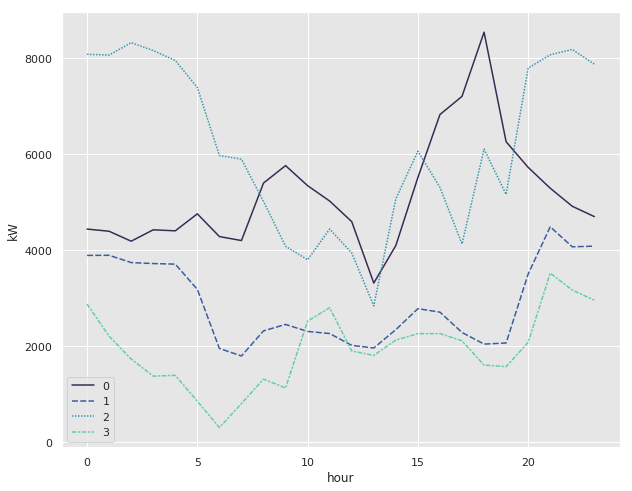

In [62]:
ax = sns.lineplot(data = df.groupby('labels').mean().T, palette = 'mako')

ax.set(ylabel='kW')

### 4.2 Affinity Propagation

<a id="affinity"></a>

In [20]:
#Load package
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation(affinity = 'euclidean')
ap.fit(cluster_dataset)

df['labels'] = ap.labels_
df.head()

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

[Text(0, 0.5, 'kW')]

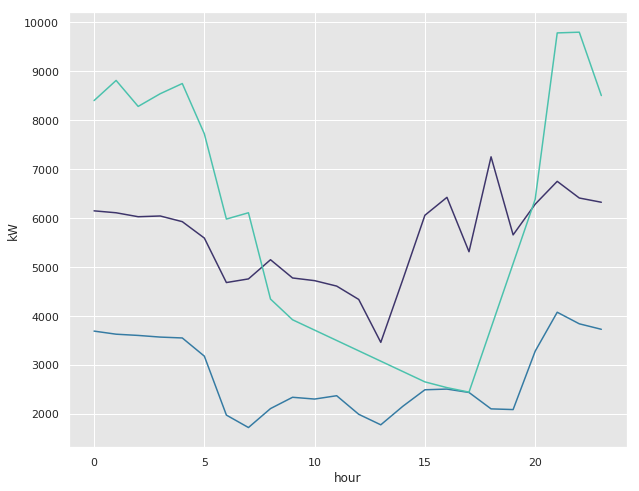

In [53]:
ax = sns.lineplot(data = df.groupby('labels').mean().T, dashes=False, legend = False, palette = 'mako')

ax.set(ylabel='kW')

### 4.3 DBSCAN

<a id="dbscan"></a>

In [23]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 3, min_samples=2)
dbscan.fit(cluster_dataset)

df['labels'] = dbscan.labels_

df.head()

hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,labels
day,,,,,,,,,,,,,,,,,,,,,,,,,
0,2642.0,3270.0,3382.0,3170.0,3495.0,3154.0,2663.0,1030.0,1778.0,1775.0,2481.0,1840.0,759.0,1139.0,1517.0,1822.0,848.0,1176.0,886.0,1437.0,3093.0,3725.0,3459.0,3304.0,0
1,3373.0,3171.0,3199.0,3095.0,3105.0,3315.0,2647.0,703.0,1673.0,2369.0,850.0,1276.0,1052.0,1557.0,1457.0,1998.0,1525.0,1411.0,1352.0,1787.0,3361.0,3430.0,4141.0,3347.0,0
2,3333.0,3157.0,3325.0,3269.0,3177.0,3338.0,2929.0,1024.0,1590.0,3689.0,1673.0,1651.0,1797.0,1007.0,1159.0,1609.0,1514.0,2592.0,1895.0,1654.0,3437.0,3563.0,3563.0,2586.0,0
3,3132.0,3419.0,3344.0,3235.0,2496.0,3285.0,2845.0,869.0,1130.0,946.0,2040.0,943.0,923.0,847.0,997.0,650.0,819.0,693.0,705.0,1204.0,3097.0,3244.0,3314.0,3098.0,0
4,3422.0,3450.0,3226.0,3131.0,3226.0,3242.0,2335.0,1032.0,762.0,919.0,795.0,1610.0,658.0,670.0,984.0,736.0,826.0,802.0,707.0,1249.0,3491.0,3248.0,3200.0,3330.0,0


[Text(0, 0.5, 'kW')]

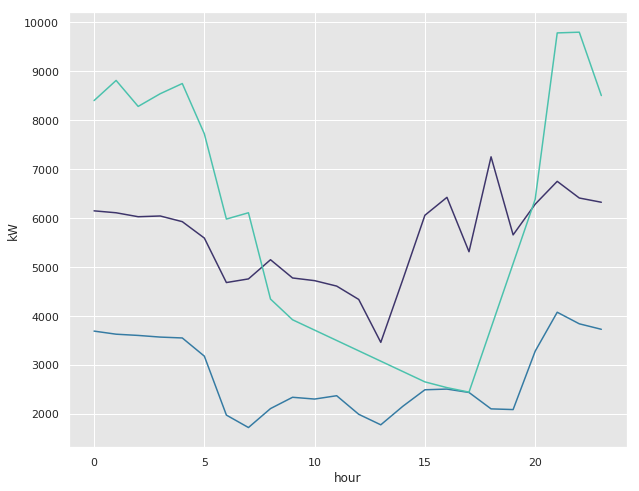

In [55]:
ax = sns.lineplot(data = df.groupby('labels').mean().T, dashes=False, legend = False, palette = 'mako')

ax.set(ylabel='kW')

## 5. Results

<a id="results"></a>

As the ground true labels of the data are uknown, according to the [scikit-learn clustering performance evaluation techniques](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) there are two metrics to use for comparing K-means, Affinity Propagation and DBSCAN clustering for the VPP demand profiling:
- Silhouette Coefficient (a higher Silhouette Coefficient score relates to a model with better defined clusters)
- Davies-Bouldin Index (a lower Davies-Bouldin index relates to a model with better separation between the clusters)

Let`s look at them

In [47]:
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

dct = {'KMeans':km, 'Affinity Propagation': ap, 'DBSCAN': dbscan}
results = []
for m in dct.keys():
    model = dct[m]
    labels = model.labels_
    sc = metrics.silhouette_score(X, labels, metric='euclidean')
    db_score = davies_bouldin_score(X, labels)
    
    metricies = [m, sc, db_score]
    results.append(metricies)
    
rslt = pd.DataFrame(results, columns = ['Clustering method', 'Silhouette Coefficient', 'Davies-Bouldin Index'])
rslt

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


,Clustering method,Silhouette Coefficient,Davies-Bouldin Index
0,KMeans,0.217761,1.646941
1,Affinity Propagation,0.121782,1.671186
2,DBSCAN,0.247649,1.793448


As we can see, results are ambiguous. The Silhouette Coefficient is highest for DBSCAN, however the Davies-Bouldin Index is highest as well. However the two metricies are usually higher for density based clustering. The Silhouette Coeff is lowest for AffinityPropagation meaning the worst defined cluster in this case. KMeans is in the middle and is considered to be a better solution for the VPP demand profiling.

## 6. Discussion

<a id="discussion"></a>

The metrics show that for the given data the three clustering method under evaluation perform badly. There are possible improvements - first of all, to add additional data on weather conditions, particularly sun radiation as we expect solar panels are used by prosumers. More accurate outliers analysis may improve the performance.  

## 7. Conclusion

<a id="discussion"></a>

The analysis of energy consumption helps to get a picture of consumers typical behaviour throught a day. The bigger the group of VPP customers the more smoothed their consumption and the better clustering performance are. Understanding the demand profiles is only the first to the VPP management system. The next step is an accurate forecasting of day-ahead values to avoid energy market fees. 